<a href="https://colab.research.google.com/github/shamim-hussain/fashion-mnist-2layer-nn/blob/main/fashion_mnist_classification_2_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Classification using a 2 Layer Neural Network
### Problem Description
We will perform a classification task on the Fashion MNIST dataset:
https://github.com/zalandoresearch/fashion-mnist
The dataset contains 28x28 grayscale(8bit) images of different fashion articles. There are 10 different classes. The training set contains 60000 examples whereas the test set contains 10000 examples. All the classes have same number of examples so it is a blanced classification problem.
### Framework of choice
We will use the Tensorflow framework for this task. We will use an object oriented approach to model definition. We will define the layers in terms of very basic equations (tensor multiplication, addition, activation etc.). Also, we will define our own custom training loop.

## Resources
* We use an object oriented model of neural network using tf.keras.models.Model. This will allow us to organize the models parameters and also initialize them.
    * https://www.tensorflow.org/api_docs/python/tf/keras/Model
    * https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class

* Forward propagation: for a 2-layer neural network only need matrix multiplication, addition and activation function to define the forward propagation.
    * Matrix multiplication: https://www.tensorflow.org/api_docs/python/tf/linalg/matmul
    * Activation functions:
        * ReLU: https://www.tensorflow.org/api_docs/python/tf/nn/relu
        * Sigmoid: https://www.tensorflow.org/api_docs/python/tf/math/sigmoid
        * Tanh: https://www.tensorflow.org/api_docs/python/tf/math/tanh

* Loss/cost function:
    * We define the cost function on the class logits. To define the crossentropy we will need to compute the log-sum-exponential, and gather the negative log likelihood of the target classes
        * https://www.tensorflow.org/api_docs/python/tf/math/reduce_logsumexp
        * https://www.tensorflow.org/api_docs/python/tf/gather
    * We also define l2 regularization on the weights, which can be computed from the squared sum of the elements
        * https://www.tensorflow.org/api_docs/python/tf/math/square
        * https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum

* We use tensorflow dataset along with tf.function (static computational graphs) for fast training/validation/test loops
    * Dataset API:
        * https://www.tensorflow.org/guide/data
        * https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    * tf.function
        * https://www.tensorflow.org/guide/function
        * https://www.tensorflow.org/api_docs/python/tf/function

* We used keras metrics to monitor the training/validation/test loss and accuracy
    * https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalCrossentropy
    * https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy

* Backward propagation and optimization: we used the "gradient tape" method the compute the gradient of the total loss function w.r.t. the network parameters. Then we use optimization algorithms from tf.keras.optimizers module to apply the calculated gradients.
    * Gradient tape and automatic differentiation
        * https://www.tensorflow.org/guide/autodiff
        * https://www.tensorflow.org/api_docs/python/tf/GradientTape
    * Optimization algorithms
        * https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
        * https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
        * https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
        

## Download the Dataset

The download links and the coad for loading the dataset in NumPy format can be found at https://github.com/zalandoresearch/fashion-mnist

In [1]:
'''From: https://github.com/zalandoresearch/fashion-mnist'''

!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-10-01 06:35:41--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.74
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.47.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  15.7MB/s    in 1.6s    

2021-10-01 06:35:43 (15.7 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-10-01 06:35:43--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.47.74
Connecting to fashion-mnist.s3-website.eu-central-1.amazona

Load the dataset in NumPy format

In [2]:

'''From: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py'''
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X_train, Y_train = load_mnist('./', kind='train') # Training set
X_test, Y_test = load_mnist('./', kind='t10k') # Test set

## Explore and Preprocess the data

Let us first explore the shape and datatypes of the examples and labels

In [3]:
print('Shape of data:', X_train.shape)
print('Type of data:', X_train.dtype)
print('Shape of data:', Y_train.shape)
print('Type of labes:', Y_train.dtype)

Shape of data: (60000, 784)
Type of data: uint8
Shape of data: (60000,)
Type of labes: uint8


We can reshape and visualized images from each class

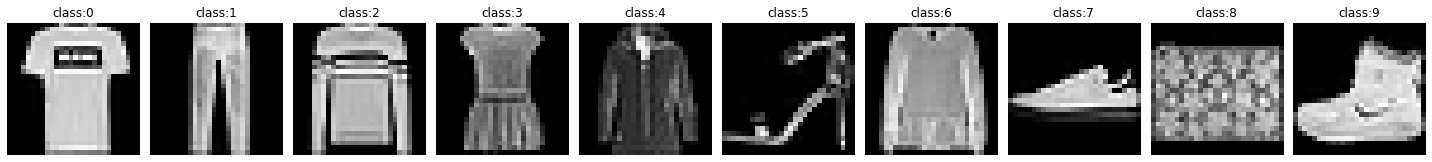

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][0]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

### Conversion into floating point input and integer target

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Y_train = Y_train.astype('int64')
Y_test = Y_test.astype('int64')

### Distribution of pixel intensities

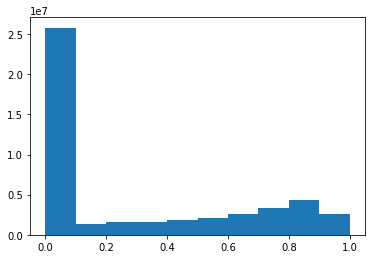

In [6]:
_ = plt.hist(X_train.reshape(-1))

### Preprocessing

#### Dimensionality reduction using PCA
From the above analysis we se that adjacent pixel intesities are highly correlated, and also the distributions of the intensities are heavy around 0. So, there is a lot of redundancy in the data, which may slow down training process and cause overfitting (since we will use a vanilla 2 layer neural network).

To prevent this we first we reduce the number of input features from 784 to 128 using PCA.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print('Number of components', X_train_pca.shape[1])

Number of components 128


Next we check the efficacy of the dimensionality reduction using a reconstruction test.

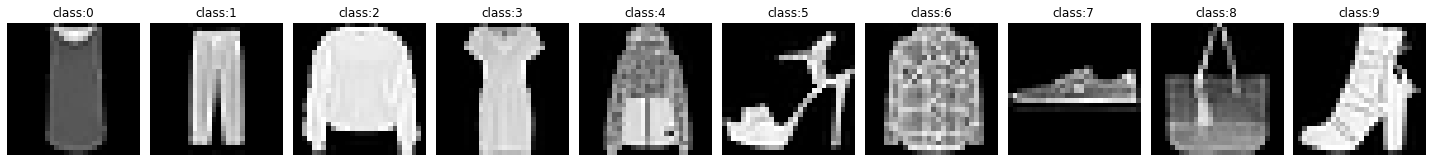

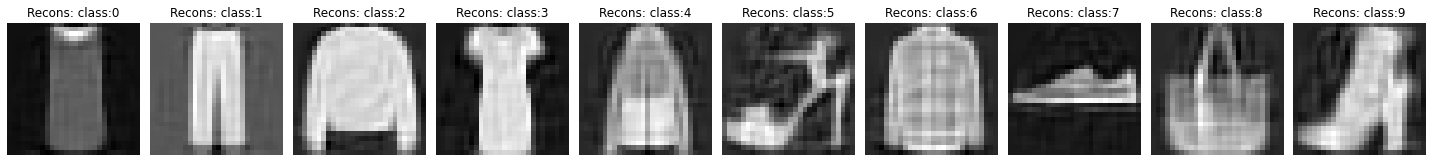

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize data
plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(X_train[np.where(Y_train==y)[0][1]].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'class:{y}')
plt.tight_layout()
plt.show()

plt.figure(figsize=[20,5])
for y in range(10):
    plt.subplot(1,10,1+y)
    plt.imshow(pca.inverse_transform(X_train_pca[np.where(Y_train==y)[0]])[1].reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title(f'Recons: class:{y}')
plt.tight_layout()
plt.show()

We see that, although some details are lost, the reconstruction are "good enough" for classification.

#### Center and scale

We will be using a vanilla neural network with L2 regularization. So, it makes sense to first center and scale the input features.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_pca)

X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)


## Train-dev(validation) split
The test data for this particular dataset is predefined. So, we only split the training data (60000) examples into 90% training and 10% validation examples.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_pca, Y_train, test_size=0.1, random_state=42)

X_test = X_test_pca

## Implementing the 2-layer neural network model
We will use tf.keras.model to define our model in an object oriented manner. This would allow for keeping track of the weights and biases and also initializing them from a random uniform distribution. However, we will define the forward propagation equations from scratch.

We will try different activation functions - ReLU, Sigmoid and Tanh for the hidden layer, also we will try different widths (no. of neurons) in the hidden layer.

In [11]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, losses, metrics
from tensorflow.data import Dataset
from tqdm import trange


num_feats = X_train.shape[1]


class NN2Layers(models.Model):
    def __init__(self, num_hidden=64, activation='relu', **kwargs):
        super().__init__(**kwargs)

        # Weights and biases
        self.W1 = self.add_weight(shape=(num_feats,num_hidden), initializer='uniform')
        self.b1 = self.add_weight(shape=(num_hidden,), initializer='uniform')
        self.W2 = self.add_weight(shape=(num_hidden,10), initializer='uniform')
        self.b2 = self.add_weight(shape=(10,), initializer='uniform')

        # Activation functions
        if activation == 'sigmoid':
            self.activation_fn = tf.nn.sigmoid
        elif activation == 'relu':
            self.activation_fn = tf.nn.relu
        elif activation == 'tanh':
            self.activation_fn = tf.nn.tanh
    
    # Forward propagation
    @tf.function
    def call(self, x):
        h1 = tf.matmul(x, self.W1) + self.b1
        a1 = self.activation_fn(h1)

        h2 = tf.matmul(a1, self.W2) + self.b2
        # No activation on the output since we will use logits to compute loss
        return h2




Now we will define the training and validation logic. We will use tensorflow datasets to shuffle the data and to form minibatches, which will allow for very fast training using tf.function (traced training loops). However, we will define the training loop from scratch.

We will define the loss/cost function (crossentropy/negative log likelihood from logits) and the l2 regularization loss on the model weights from scratch. However, we will use builtin metrics to monitor the loss and the accuracy during training.

During training we keep track of the training and the validations losses and accuracy to monitor the convergence and also possible overfitting.

We employed and exponential learning rate decay scheme for good convergence.


In [14]:

def train_model(X_t, Y_t, X_v, Y_v, model, optimizer='sgd', batch_size=32,
                  epochs=100, initial_lr=1e-2, decay=0.985, l2_loss=0.):
    # Tensorflow dataset, used in conjunction with tf.function for fast training loops
    train_dset = Dataset.from_tensor_slices((X_t, Y_t)).shuffle(len(X_t)).batch(batch_size)
    validation_dset = Dataset.from_tensor_slices((X_v, Y_v)).batch(batch_size)

    # Optimizer
    if optimizer == 'adam':
        optimizer = optimizers.Adam(initial_lr)
    if optimizer == 'rmsprop':
        optimizer = optimizers.RMSprop(initial_lr)
    if optimizer == 'sgd':
        optimizer = optimizers.SGD(initial_lr, momentum=0.5)
    
    # Crossentropy metric
    loss_metric = metrics.SparseCategoricalCrossentropy(from_logits=True)
    # Accuracy metric
    acc_metric = metrics.SparseCategoricalAccuracy()

    # Negative log likelihood/ crossentropy loss from logits
    @tf.function
    def loss_fn(targets, logits):
        neg_log_likelihood = tf.reduce_logsumexp(logits,axis=-1,
                                                 keepdims=True) - logits
        loss = tf.gather(neg_log_likelihood, targets, batch_dims=1)
        return tf.reduce_mean(loss)

    # L2 regularization on the weights
    @tf.function
    def l2_loss_fn():
        return tf.reduce_sum(tf.square(model.W1)) + \
                tf.reduce_sum(tf.square(model.W2))
    
    # Training loop
    @tf.function
    def training_loop():
        for X,Y in train_dset:
            with tf.GradientTape() as tape:
                Y_p = model(X)
                loss = loss_fn(Y,Y_p) + l2_loss*l2_loss_fn()

            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads,model.trainable_variables))
            loss_metric.update_state(Y,Y_p)
            acc_metric.update_state(Y,Y_p)
    
    # Validation loop
    @tf.function
    def validation_loop():
        for X,Y in validation_dset:
            Y_p = model(X)
            loss_metric.update_state(Y,Y_p)
            acc_metric.update_state(Y,Y_p)


    # Historical losses and accuracies
    training_losses = []
    training_accs = []
    validation_losses = []
    validation_accs = []

    gen = trange(epochs)
    try:
        for epoch in gen:
            # Training epoch
            loss_metric.reset_state()
            acc_metric.reset_state()
            training_loop()
            training_loss=loss_metric.result().numpy()
            training_acc=acc_metric.result().numpy()

            
            # Validation epoch
            loss_metric.reset_state()
            acc_metric.reset_state()
            validation_loop()
            validation_loss=loss_metric.result().numpy()
            validation_acc=acc_metric.result().numpy()

            optimizer.lr.assign(optimizer.lr*decay)

            gen.set_description(f'LR: {optimizer.lr.numpy():.3e} :: '+
                                f'Training: loss={training_loss:0.4f}; acc={training_acc:.3%} :: '+
                                f'Validation: loss={validation_loss:0.4f}; acc={validation_acc:.3%} ')
            
            training_losses.append(training_loss)
            training_accs.append(training_acc)
            validation_losses.append(validation_loss)
            validation_accs.append(validation_acc)
    finally:
        gen.close()
    
    return training_losses, training_accs, validation_losses, validation_accs



Now we instantiate the model and train it

In [16]:
# Instantiate the model
model=NN2Layers(num_hidden=128, activation='relu')

# Train the model
training_losses, training_accs, validation_losses, validation_accs = \
train_model(X_train, Y_train, X_val, Y_val, 
            model = model, 
            optimizer = 'adam', 
            batch_size = 32, 
            epochs = 200, 
            initial_lr = 1e-3, 
            decay = 0.985, 
            l2_loss = 1e-3)

LR: 4.867e-05 :: Training: loss=0.1915; acc=94.485% :: Validation: loss=0.3022; acc=89.450% : 100%|██████████| 200/200 [05:06<00:00,  1.53s/it]


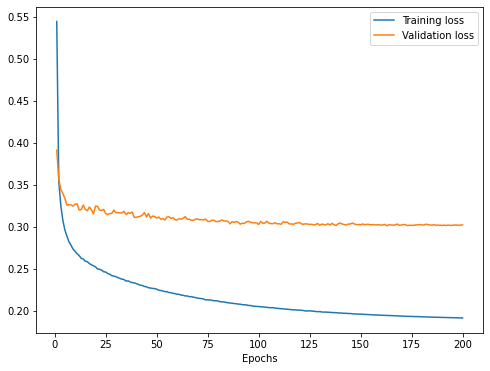

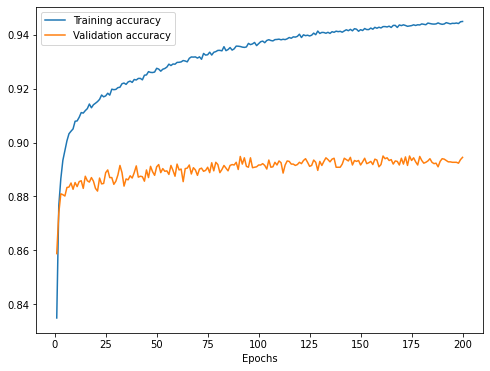

In [20]:
import matplotlib.pyplot as plt

epochs = list(range(1,len(training_losses)+1))

plt.figure(figsize=[8,6])
plt.plot(epochs, training_losses, label='Training loss')
plt.plot(epochs, validation_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.show()

plt.figure(figsize=[8,6])
plt.plot(epochs, training_accs, label='Training accuracy')
plt.plot(epochs, validation_accs, label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.show()

We see from the training curves that we have both good convergence and no signs of overfitting (U shape). The validation loss has sufficiently plateaued so the number of epochs trained is adequate.

## Final results on the test set

In [22]:
test_dset = Dataset.from_tensor_slices((X_test, Y_test)).batch(32)

# Crossentropy metric
loss_metric = metrics.SparseCategoricalCrossentropy(from_logits=True)
# Accuracy metric
acc_metric = metrics.SparseCategoricalAccuracy()

# Test loop
@tf.function
def test_loop():
    for X,Y in test_dset:
        Y_p = model(X)
        loss_metric.update_state(Y,Y_p)
        acc_metric.update_state(Y,Y_p)

test_loop()
print(f'Test crossentropy = {loss_metric.result().numpy():.4f}')
print(f'Test accuracy = {acc_metric.result().numpy():.3%}')


Test crossentropy = 0.3117
Test accuracy = 89.120%


## Design choices and hyperparameter selection

* We performed PCA on the input pixel intensities. We verified that increasing the dimensionality beyond 128 does not significantly improve classification performance - rather slows down training and may contribute to overfitting.
* Without L2 regularization of the weights (not biases) the model begins to overfit after a given number of epochs. L2 regularization leads to better validation loss and accuracy.
* All three of the activation functions (ReLU, sigmoid, tanh) had approximately similar results, however ReLU had the best validation results so we chose it for the final model.
* We tried 3 different model widths, 64, 128 and 256. Along with L2 regulariation, a width of 128 performed best.
* We tried 3 different optimization algorithms - SGD with momentum, RMSProp and Adam. Adam had the fastest convergence and also the best final validation results. So, it was chosen for the final training.
* We used the default initial learning rates for the optimizers - 0.01 for SGD and 0.001 for Adam and RMSProp because these values worked well enough. The learning rate decay was chosen for best convergence characteristic.